In [ ]:
!pip install wandb

In [6]:
import wandb
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import wandb
from tqdm import tqdm
import time

In [2]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nipkha21 (nipkha21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from data_utils import load_split_data, FacialExpressionDataset, get_transforms
from models import AdvancedCNN, ResidualBlock, get_model
from training_utils import ModelTrainer, get_optimizer, get_scheduler

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class CNNFacialExpressionDataset(Dataset):
    def __init__(self, data, transform=None, augment=False, is_test=False):
        self.data = data
        self.transform = transform
        self.augment = augment
        self.is_test = is_test

        self.augment_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.base_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array([int(pixel) for pixel in pixels.split()], dtype=np.uint8)
        image = image.reshape(48, 48)

        if self.augment and not self.is_test:
            image = self.augment_transform(image)
        else:
            image = self.base_transform(image)

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            emotion = int(self.data.iloc[idx]['emotion'])
            return image, emotion

In [9]:
class CNNTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,
                 scheduler=None, device='cuda', experiment_name='experiment', run_name='run'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        wandb.init(
            project="facial-expression-recognition",
            group=experiment_name,
            name=run_name,
            config={
                "data_split_method": "predefined_stratified",
                "train_samples": len(train_loader.dataset),
                "val_samples": len(val_loader.dataset),
                "split_random_state": 42
            },
            reinit=True
        )
        wandb.watch(self.model, log='all', log_freq=100)

        self.history = {
            'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
            'learning_rates': [], 'epoch_times': []
        }
        self.best_val_acc = 0.0
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, targets in tqdm(self.val_loader, desc="Validation"):
                data, targets = data.to(self.device), targets.to(self.device)

                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, np.array(all_predictions), np.array(all_targets)

    def train(self, epochs, early_stopping_patience=10):
        print(f"Starting training for {epochs} epochs...")

        patience_counter = 0

        for epoch in range(epochs):
            epoch_start = time.time()

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, val_preds, val_targets = self.validate_epoch()

            current_lr = self.optimizer.param_groups[0]['lr']
            if self.scheduler:
                if isinstance(self.scheduler, ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            epoch_time = time.time() - epoch_start

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            self.history['epoch_times'].append(epoch_time)

            loss_gap = val_loss - train_loss
            acc_gap = train_acc - val_acc

            log_dict = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'learning_rate': current_lr,
                'epoch_time': epoch_time,
                'loss_gap': loss_gap,
                'accuracy_gap': acc_gap,
                'overfitting_score': loss_gap + (acc_gap / 100),
                'best_val_accuracy': self.best_val_acc
            }

            if (epoch + 1) % 10 == 0:
                emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
                log_dict['confusion_matrix'] = wandb.plot.confusion_matrix(
                    probs=None, y_true=val_targets, preds=val_preds,
                    class_names=list(emotion_map.values())
                )

            wandb.log(log_dict)

            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"  LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
            print(f"  Overfitting Score: {loss_gap + (acc_gap / 100):.4f}")
            print("-" * 50)

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print(f"Loaded best model with validation accuracy: {self.best_val_acc:.2f}%")

        return self.history

In [11]:
wandb.login()

print("=== LOADING PRE-SPLIT DATA ===")

train_df, val_df, test_df = load_split_data('drive/MyDrive/data')

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

=== LOADING PRE-SPLIT DATA ===


In [13]:
print("=== AUGMENTATION STRATEGY EXPERIMENTS ===")

augmentation_configs = {
    'none': {'augment': False, 'name': 'no_augmentation'},
    'basic': {'augment': True, 'name': 'basic_augmentation'},
    'aggressive': {'augment': True, 'name': 'aggressive_augmentation'}
}

class AggressiveAugmentDataset(CNNFacialExpressionDataset):
    def __init__(self, data, is_test=False):
        super().__init__(data, is_test=is_test)

        self.augment_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.7),
            transforms.RandomRotation(degrees=20),
            transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.8, 1.2)),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

augmentation_results = {}

for aug_name, aug_config in augmentation_configs.items():
    print(f"\nTesting augmentation: {aug_name}")

    if aug_name == 'aggressive':
        train_dataset = AggressiveAugmentDataset(train_df)
        val_dataset = CNNFacialExpressionDataset(val_df, augment=False)
    else:
        train_dataset = CNNFacialExpressionDataset(train_df, augment=aug_config['augment'])
        val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = AdvancedCNN(num_classes=7, dropout_rate=0.3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trainer = CNNTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Advanced_CNN_Training",
        run_name=f"Augmentation_{aug_name}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=5)

    augmentation_results[aug_name] = {
        'best_val_acc': trainer.best_val_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'training_time': sum(history['epoch_times'])
    }

    wandb.finish()

    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")

print("\n=== AUGMENTATION ANALYSIS ===")
best_augmentation = max(augmentation_results.keys(), key=lambda x: augmentation_results[x]['best_val_acc'])
print(f"Best augmentation strategy: {best_augmentation}")

for aug_name, results in augmentation_results.items():
    print(f"{aug_name}: {results['best_val_acc']:.2f}%")

=== AUGMENTATION STRATEGY EXPERIMENTS ===

Testing augmentation: none


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.81it/s]


Epoch 1/10:
  Train Loss: 1.6748, Train Acc: 35.87%
  Val Loss: 1.4468, Val Acc: 44.58%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: -0.3151
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]


Epoch 2/10:
  Train Loss: 1.3866, Train Acc: 47.03%
  Val Loss: 1.2988, Val Acc: 50.48%
  LR: 0.001000, Time: 29.83s
  Overfitting Score: -0.1222
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.86it/s]


Epoch 3/10:
  Train Loss: 1.2564, Train Acc: 52.44%
  Val Loss: 1.2529, Val Acc: 52.24%
  LR: 0.001000, Time: 29.75s
  Overfitting Score: -0.0015
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.13it/s]


Epoch 4/10:
  Train Loss: 1.1510, Train Acc: 56.50%
  Val Loss: 1.2157, Val Acc: 53.10%
  LR: 0.001000, Time: 29.81s
  Overfitting Score: 0.0986
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 5/10:
  Train Loss: 1.0464, Train Acc: 60.92%
  Val Loss: 1.3048, Val Acc: 52.94%
  LR: 0.001000, Time: 29.88s
  Overfitting Score: 0.3382
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.95it/s]


Epoch 6/10:
  Train Loss: 0.9276, Train Acc: 65.48%
  Val Loss: 1.2159, Val Acc: 55.68%
  LR: 0.001000, Time: 29.97s
  Overfitting Score: 0.3864
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.11it/s]


Epoch 7/10:
  Train Loss: 0.7690, Train Acc: 71.64%
  Val Loss: 1.3071, Val Acc: 55.75%
  LR: 0.001000, Time: 29.84s
  Overfitting Score: 0.6970
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 8/10:
  Train Loss: 0.6189, Train Acc: 77.23%
  Val Loss: 1.4599, Val Acc: 55.37%
  LR: 0.001000, Time: 29.91s
  Overfitting Score: 1.0595
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.06it/s]


Epoch 9/10:
  Train Loss: 0.4762, Train Acc: 82.52%
  Val Loss: 1.5259, Val Acc: 55.96%
  LR: 0.001000, Time: 29.74s
  Overfitting Score: 1.3154
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.87it/s]


Epoch 10/10:
  Train Loss: 0.3628, Train Acc: 86.97%
  Val Loss: 1.8203, Val Acc: 56.86%
  LR: 0.001000, Time: 29.91s
  Overfitting Score: 1.7585
--------------------------------------------------
Loaded best model with validation accuracy: 56.86%


accuracy_gap,▁▂▃▃▄▄▅▇▇█
best_val_accuracy,▁▄▅▆▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▃▁▂▃▅▃▄▁▄
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▃▄▅▆█
overfitting_score,▁▂▂▂▃▃▄▆▇█
train_accuracy,▁▃▃▄▄▅▆▇▇█
train_loss,█▆▆▅▅▄▃▂▂▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,▄▂▁▁▂▁▂▄▅█


Best validation accuracy: 56.86%

Testing augmentation: basic


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.38it/s]


Epoch 1/10:
  Train Loss: 1.8141, Train Acc: 28.71%
  Val Loss: 1.5809, Val Acc: 37.54%
  LR: 0.001000, Time: 38.85s
  Overfitting Score: -0.3215
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.59it/s]


Epoch 2/10:
  Train Loss: 1.5537, Train Acc: 39.36%
  Val Loss: 1.4312, Val Acc: 44.49%
  LR: 0.001000, Time: 38.74s
  Overfitting Score: -0.1738
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.91it/s]


Epoch 3/10:
  Train Loss: 1.4375, Train Acc: 45.08%
  Val Loss: 1.2986, Val Acc: 49.38%
  LR: 0.001000, Time: 38.80s
  Overfitting Score: -0.1819
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.23it/s]


Epoch 4/10:
  Train Loss: 1.3822, Train Acc: 47.14%
  Val Loss: 1.2313, Val Acc: 52.91%
  LR: 0.001000, Time: 38.83s
  Overfitting Score: -0.2087
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.03it/s]


Epoch 5/10:
  Train Loss: 1.3329, Train Acc: 48.93%
  Val Loss: 1.3404, Val Acc: 49.64%
  LR: 0.001000, Time: 38.86s
  Overfitting Score: 0.0004
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.17it/s]


Epoch 6/10:
  Train Loss: 1.2934, Train Acc: 51.29%
  Val Loss: 1.2327, Val Acc: 53.54%
  LR: 0.001000, Time: 38.91s
  Overfitting Score: -0.0832
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.18it/s]


Epoch 7/10:
  Train Loss: 1.2688, Train Acc: 52.36%
  Val Loss: 1.1825, Val Acc: 54.82%
  LR: 0.001000, Time: 38.78s
  Overfitting Score: -0.1109
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.61it/s]


Epoch 8/10:
  Train Loss: 1.2400, Train Acc: 53.27%
  Val Loss: 1.1357, Val Acc: 56.21%
  LR: 0.001000, Time: 38.95s
  Overfitting Score: -0.1337
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.86it/s]


Epoch 9/10:
  Train Loss: 1.2187, Train Acc: 54.00%
  Val Loss: 1.1607, Val Acc: 55.49%
  LR: 0.001000, Time: 38.85s
  Overfitting Score: -0.0729
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.83it/s]

Epoch 10/10:
  Train Loss: 1.1986, Train Acc: 54.74%
  Val Loss: 1.1256, Val Acc: 56.74%
  LR: 0.001000, Time: 38.93s
  Overfitting Score: -0.0930
--------------------------------------------------
Loaded best model with validation accuracy: 56.74%


accuracy_gap,▁▄▅▄█▇▆▆▇▇
best_val_accuracy,▁▄▅▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▅▁▃▄▅▇▂█▅▇
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▄▄▃█▆▅▅▆▆
overfitting_score,▁▄▄▃█▆▆▅▆▆
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▇▅▇▇███
val_loss,█▆▄▃▄▃▂▁▂▁


Best validation accuracy: 56.74%

Testing augmentation: aggressive


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.84it/s]


Epoch 1/10:
  Train Loss: 1.6714, Train Acc: 36.17%
  Val Loss: 1.4136, Val Acc: 44.67%
  LR: 0.001000, Time: 30.08s
  Overfitting Score: -0.3428
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.60it/s]


Epoch 2/10:
  Train Loss: 1.3821, Train Acc: 46.89%
  Val Loss: 1.3053, Val Acc: 50.38%
  LR: 0.001000, Time: 30.16s
  Overfitting Score: -0.1117
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.80it/s]


Epoch 3/10:
  Train Loss: 1.2500, Train Acc: 52.97%
  Val Loss: 1.2293, Val Acc: 52.61%
  LR: 0.001000, Time: 30.13s
  Overfitting Score: -0.0171
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.78it/s]


Epoch 4/10:
  Train Loss: 1.1443, Train Acc: 56.64%
  Val Loss: 1.2213, Val Acc: 53.08%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: 0.1126
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.36it/s]


Epoch 5/10:
  Train Loss: 1.0389, Train Acc: 60.96%
  Val Loss: 1.2357, Val Acc: 53.77%
  LR: 0.001000, Time: 30.23s
  Overfitting Score: 0.2687
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.73it/s]


Epoch 6/10:
  Train Loss: 0.9022, Train Acc: 66.47%
  Val Loss: 1.2451, Val Acc: 55.98%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: 0.4478
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 7/10:
  Train Loss: 0.7533, Train Acc: 72.38%
  Val Loss: 1.2951, Val Acc: 56.16%
  LR: 0.001000, Time: 30.16s
  Overfitting Score: 0.7039
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.56it/s]


Epoch 8/10:
  Train Loss: 0.5932, Train Acc: 78.57%
  Val Loss: 1.4472, Val Acc: 56.95%
  LR: 0.001000, Time: 30.23s
  Overfitting Score: 1.0702
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.90it/s]


Epoch 9/10:
  Train Loss: 0.4631, Train Acc: 83.51%
  Val Loss: 1.6012, Val Acc: 55.58%
  LR: 0.001000, Time: 30.28s
  Overfitting Score: 1.4173
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.14it/s]


Epoch 10/10:
  Train Loss: 0.3602, Train Acc: 87.05%
  Val Loss: 1.7871, Val Acc: 54.47%
  LR: 0.001000, Time: 30.17s
  Overfitting Score: 1.7527
--------------------------------------------------
Loaded best model with validation accuracy: 56.95%


accuracy_gap,▁▂▃▃▄▄▅▆▇█
best_val_accuracy,▁▄▆▆▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▄▃▃▆▃▄▆█▄
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▃▄▆▇█
overfitting_score,▁▂▂▃▃▄▄▆▇█
train_accuracy,▁▂▃▄▄▅▆▇██
train_loss,█▆▆▅▅▄▃▂▂▁
val_accuracy,▁▄▆▆▆▇██▇▇
val_loss,▃▂▁▁▁▁▂▄▆█


Best validation accuracy: 56.95%

=== AUGMENTATION ANALYSIS ===
Best augmentation strategy: aggressive
none: 56.86%
basic: 56.74%
aggressive: 56.95%


In [14]:
print("=== OPTIMIZER COMPARISON ===")

optimizers_config = {
    'adam': {'class': optim.Adam, 'kwargs': {'lr': 0.001}},
    'adamw': {'class': optim.AdamW, 'kwargs': {'lr': 0.001, 'weight_decay': 0.01}},
    'sgd': {'class': optim.SGD, 'kwargs': {'lr': 0.01, 'momentum': 0.9}},
    'sgd_nesterov': {'class': optim.SGD, 'kwargs': {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}},
    'rmsprop': {'class': optim.RMSprop, 'kwargs': {'lr': 0.001, 'alpha': 0.99}}
}

optimizer_results = {}

for opt_name, opt_config in optimizers_config.items():
    print(f"\nTesting optimizer: {opt_name}")

    if best_augmentation == 'aggressive':
        train_dataset = AggressiveAugmentDataset(train_df)
    else:
        train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
    val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = AdvancedCNN(num_classes=7, dropout_rate=0.3)
    criterion = nn.CrossEntropyLoss()
    optimizer = opt_config['class'](model.parameters(), **opt_config['kwargs'])

    trainer = CNNTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Advanced_CNN_Training",
        run_name=f"Optimizer_{opt_name}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=7)

    optimizer_results[opt_name] = {
        'best_val_acc': trainer.best_val_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'training_stability': np.std(history['val_acc'][-10:])
    }

    wandb.finish()

    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")

print("\n=== OPTIMIZER ANALYSIS ===")
best_optimizer = max(optimizer_results.keys(), key=lambda x: optimizer_results[x]['best_val_acc'])
print(f"Best optimizer: {best_optimizer}")

for opt_name, results in optimizer_results.items():
    print(f"{opt_name}: {results['best_val_acc']:.2f}% (stability: {results['training_stability']:.4f})")

=== OPTIMIZER COMPARISON ===

Testing optimizer: adam


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]


Epoch 1/10:
  Train Loss: 1.6675, Train Acc: 36.36%
  Val Loss: 1.4554, Val Acc: 43.23%
  LR: 0.001000, Time: 30.45s
  Overfitting Score: -0.2809
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.28it/s]


Epoch 2/10:
  Train Loss: 1.3793, Train Acc: 47.37%
  Val Loss: 1.2848, Val Acc: 50.66%
  LR: 0.001000, Time: 30.32s
  Overfitting Score: -0.1275
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 3/10:
  Train Loss: 1.2611, Train Acc: 52.09%
  Val Loss: 1.2241, Val Acc: 53.26%
  LR: 0.001000, Time: 30.22s
  Overfitting Score: -0.0487
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 4/10:
  Train Loss: 1.1499, Train Acc: 56.86%
  Val Loss: 1.1874, Val Acc: 55.12%
  LR: 0.001000, Time: 30.20s
  Overfitting Score: 0.0549
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.24it/s]


Epoch 5/10:
  Train Loss: 1.0398, Train Acc: 61.01%
  Val Loss: 1.2007, Val Acc: 54.17%
  LR: 0.001000, Time: 30.27s
  Overfitting Score: 0.2292
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 6/10:
  Train Loss: 0.9108, Train Acc: 66.13%
  Val Loss: 1.1991, Val Acc: 56.00%
  LR: 0.001000, Time: 30.22s
  Overfitting Score: 0.3896
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 7/10:
  Train Loss: 0.7656, Train Acc: 71.77%
  Val Loss: 1.2650, Val Acc: 57.21%
  LR: 0.001000, Time: 30.21s
  Overfitting Score: 0.6450
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.50it/s]


Epoch 8/10:
  Train Loss: 0.6052, Train Acc: 77.95%
  Val Loss: 1.4686, Val Acc: 55.12%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 1.0917
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.71it/s]


Epoch 9/10:
  Train Loss: 0.4687, Train Acc: 82.99%
  Val Loss: 1.5773, Val Acc: 55.82%
  LR: 0.001000, Time: 30.21s
  Overfitting Score: 1.3803
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.33it/s]

Epoch 10/10:
  Train Loss: 0.3671, Train Acc: 87.08%
  Val Loss: 1.7517, Val Acc: 55.44%
  LR: 0.001000, Time: 30.34s
  Overfitting Score: 1.7010
--------------------------------------------------
Loaded best model with validation accuracy: 57.21%


accuracy_gap,▁▂▂▃▃▄▅▆▇█
best_val_accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▅▃▂▄▃▂▁▂▅
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▃▄▆▇█
overfitting_score,▁▂▂▂▃▃▄▆▇█
train_accuracy,▁▃▃▄▄▅▆▇▇█
train_loss,█▆▆▅▅▄▃▂▂▁
val_accuracy,▁▅▆▇▆▇█▇▇▇
val_loss,▄▂▁▁▁▁▂▄▆█


Best validation accuracy: 57.21%

Testing optimizer: adamw


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.00it/s]


Epoch 1/10:
  Train Loss: 1.6799, Train Acc: 35.51%
  Val Loss: 1.4409, Val Acc: 43.81%
  LR: 0.001000, Time: 30.16s
  Overfitting Score: -0.3220
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.36it/s]


Epoch 2/10:
  Train Loss: 1.3894, Train Acc: 46.86%
  Val Loss: 1.3601, Val Acc: 47.64%
  LR: 0.001000, Time: 30.25s
  Overfitting Score: -0.0372
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 3/10:
  Train Loss: 1.2564, Train Acc: 52.34%
  Val Loss: 1.2226, Val Acc: 53.59%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: -0.0463
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.71it/s]


Epoch 4/10:
  Train Loss: 1.1502, Train Acc: 56.73%
  Val Loss: 1.2257, Val Acc: 53.96%
  LR: 0.001000, Time: 30.28s
  Overfitting Score: 0.1032
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.20it/s]


Epoch 5/10:
  Train Loss: 1.0468, Train Acc: 60.89%
  Val Loss: 1.1947, Val Acc: 54.79%
  LR: 0.001000, Time: 30.31s
  Overfitting Score: 0.2088
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.68it/s]


Epoch 6/10:
  Train Loss: 0.9210, Train Acc: 65.96%
  Val Loss: 1.2074, Val Acc: 56.00%
  LR: 0.001000, Time: 30.30s
  Overfitting Score: 0.3860
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 7/10:
  Train Loss: 0.7776, Train Acc: 71.56%
  Val Loss: 1.2526, Val Acc: 56.42%
  LR: 0.001000, Time: 30.20s
  Overfitting Score: 0.6264
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 8/10:
  Train Loss: 0.6207, Train Acc: 77.44%
  Val Loss: 1.4064, Val Acc: 55.65%
  LR: 0.001000, Time: 30.25s
  Overfitting Score: 1.0036
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]


Epoch 9/10:
  Train Loss: 0.4765, Train Acc: 82.64%
  Val Loss: 1.5732, Val Acc: 56.70%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 1.3561
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.18it/s]

Epoch 10/10:
  Train Loss: 0.3747, Train Acc: 86.77%
  Val Loss: 1.7865, Val Acc: 54.96%
  LR: 0.001000, Time: 30.28s
  Overfitting Score: 1.7299
--------------------------------------------------
Loaded best model with validation accuracy: 56.70%


accuracy_gap,▁▂▂▃▄▄▅▆▇█
best_val_accuracy,▁▃▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▂▆▁▇██▃▅▁▆
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▃▄▅▇█
overfitting_score,▁▂▂▂▃▃▄▆▇█
train_accuracy,▁▃▃▄▄▅▆▇▇█
train_loss,█▆▆▅▅▄▃▂▂▁
val_accuracy,▁▃▆▇▇██▇█▇
val_loss,▄▃▁▁▁▁▂▄▅█


Best validation accuracy: 56.70%

Testing optimizer: sgd


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.72it/s]


Epoch 1/10:
  Train Loss: 1.9324, Train Acc: 25.53%
  Val Loss: 1.6143, Val Acc: 35.57%
  LR: 0.010000, Time: 29.98s
  Overfitting Score: -0.4185
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.12it/s]


Epoch 2/10:
  Train Loss: 1.6325, Train Acc: 37.23%
  Val Loss: 1.4911, Val Acc: 42.14%
  LR: 0.010000, Time: 29.93s
  Overfitting Score: -0.1905
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.76it/s]


Epoch 3/10:
  Train Loss: 1.4520, Train Acc: 44.00%
  Val Loss: 1.4031, Val Acc: 46.39%
  LR: 0.010000, Time: 29.87s
  Overfitting Score: -0.0728
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.63it/s]


Epoch 4/10:
  Train Loss: 1.3167, Train Acc: 49.77%
  Val Loss: 1.4079, Val Acc: 47.09%
  LR: 0.010000, Time: 29.94s
  Overfitting Score: 0.1181
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.49it/s]


Epoch 5/10:
  Train Loss: 1.1760, Train Acc: 55.95%
  Val Loss: 1.3757, Val Acc: 48.78%
  LR: 0.010000, Time: 29.93s
  Overfitting Score: 0.2714
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.84it/s]


Epoch 6/10:
  Train Loss: 1.0167, Train Acc: 62.31%
  Val Loss: 1.3937, Val Acc: 50.38%
  LR: 0.010000, Time: 29.86s
  Overfitting Score: 0.4962
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.44it/s]


Epoch 7/10:
  Train Loss: 0.8532, Train Acc: 68.86%
  Val Loss: 1.4793, Val Acc: 50.13%
  LR: 0.010000, Time: 30.03s
  Overfitting Score: 0.8134
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.47it/s]


Epoch 8/10:
  Train Loss: 0.6836, Train Acc: 75.15%
  Val Loss: 1.5896, Val Acc: 50.50%
  LR: 0.010000, Time: 29.95s
  Overfitting Score: 1.1525
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.77it/s]


Epoch 9/10:
  Train Loss: 0.5412, Train Acc: 81.13%
  Val Loss: 1.7081, Val Acc: 51.20%
  LR: 0.010000, Time: 29.89s
  Overfitting Score: 1.4662
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.21it/s]


Epoch 10/10:
  Train Loss: 0.4142, Train Acc: 85.69%
  Val Loss: 1.8037, Val Acc: 50.57%
  LR: 0.010000, Time: 30.06s
  Overfitting Score: 1.7407
--------------------------------------------------
Loaded best model with validation accuracy: 51.20%


accuracy_gap,▁▂▂▃▄▄▅▆▇█
best_val_accuracy,▁▄▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▅▃▁▄▃▁▇▄▂█
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▃▃▄▅▆▇█
overfitting_score,▁▂▂▃▃▄▅▆▇█
train_accuracy,▁▂▃▄▅▅▆▇▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▄▆▆▇█████
val_loss,▅▃▁▂▁▁▃▄▆█


Best validation accuracy: 51.20%

Testing optimizer: sgd_nesterov


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.41it/s]


Epoch 1/10:
  Train Loss: 1.9260, Train Acc: 26.58%
  Val Loss: 1.6102, Val Acc: 36.89%
  LR: 0.010000, Time: 29.99s
  Overfitting Score: -0.4189
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.17it/s]


Epoch 2/10:
  Train Loss: 1.6160, Train Acc: 37.43%
  Val Loss: 1.4888, Val Acc: 43.19%
  LR: 0.010000, Time: 30.09s
  Overfitting Score: -0.1847
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.75it/s]


Epoch 3/10:
  Train Loss: 1.4492, Train Acc: 44.51%
  Val Loss: 1.4166, Val Acc: 45.79%
  LR: 0.010000, Time: 29.81s
  Overfitting Score: -0.0454
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.51it/s]


Epoch 4/10:
  Train Loss: 1.3018, Train Acc: 50.34%
  Val Loss: 1.3608, Val Acc: 47.60%
  LR: 0.010000, Time: 30.00s
  Overfitting Score: 0.0864
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.25it/s]


Epoch 5/10:
  Train Loss: 1.1574, Train Acc: 56.46%
  Val Loss: 1.3474, Val Acc: 48.22%
  LR: 0.010000, Time: 29.92s
  Overfitting Score: 0.2723
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.84it/s]


Epoch 6/10:
  Train Loss: 0.9996, Train Acc: 62.65%
  Val Loss: 1.3730, Val Acc: 50.22%
  LR: 0.010000, Time: 30.03s
  Overfitting Score: 0.4977
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.56it/s]


Epoch 7/10:
  Train Loss: 0.8267, Train Acc: 69.73%
  Val Loss: 1.4657, Val Acc: 49.13%
  LR: 0.010000, Time: 29.87s
  Overfitting Score: 0.8450
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.44it/s]


Epoch 8/10:
  Train Loss: 0.6681, Train Acc: 76.00%
  Val Loss: 1.5574, Val Acc: 49.48%
  LR: 0.010000, Time: 29.86s
  Overfitting Score: 1.1545
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 9/10:
  Train Loss: 0.5079, Train Acc: 82.10%
  Val Loss: 1.7428, Val Acc: 49.01%
  LR: 0.010000, Time: 29.87s
  Overfitting Score: 1.5658
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.42it/s]


Epoch 10/10:
  Train Loss: 0.3941, Train Acc: 86.43%
  Val Loss: 1.8655, Val Acc: 49.55%
  LR: 0.010000, Time: 29.86s
  Overfitting Score: 1.8402
--------------------------------------------------
Loaded best model with validation accuracy: 50.22%


accuracy_gap,▁▂▂▃▄▄▆▆▇█
best_val_accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▆█▁▆▄▆▂▂▃▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▄▅▆▇█
overfitting_score,▁▂▂▃▃▄▅▆▇█
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▄▆▇▇█▇█▇█
val_loss,▅▃▂▁▁▁▃▄▆█


Best validation accuracy: 50.22%

Testing optimizer: rmsprop


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.78it/s]


Epoch 1/10:
  Train Loss: 1.7409, Train Acc: 32.90%
  Val Loss: 1.5164, Val Acc: 41.86%
  LR: 0.001000, Time: 30.12s
  Overfitting Score: -0.3141
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.15it/s]


Epoch 2/10:
  Train Loss: 1.4310, Train Acc: 44.42%
  Val Loss: 1.3172, Val Acc: 48.22%
  LR: 0.001000, Time: 30.19s
  Overfitting Score: -0.1517
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.63it/s]


Epoch 3/10:
  Train Loss: 1.2891, Train Acc: 50.66%
  Val Loss: 1.2705, Val Acc: 51.43%
  LR: 0.001000, Time: 30.02s
  Overfitting Score: -0.0263
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.19it/s]


Epoch 4/10:
  Train Loss: 1.1827, Train Acc: 55.23%
  Val Loss: 1.2628, Val Acc: 52.26%
  LR: 0.001000, Time: 30.22s
  Overfitting Score: 0.1098
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.31it/s]


Epoch 5/10:
  Train Loss: 1.0693, Train Acc: 59.92%
  Val Loss: 1.2007, Val Acc: 54.59%
  LR: 0.001000, Time: 30.21s
  Overfitting Score: 0.1847
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.75it/s]


Epoch 6/10:
  Train Loss: 0.9519, Train Acc: 64.58%
  Val Loss: 1.2202, Val Acc: 55.35%
  LR: 0.001000, Time: 30.08s
  Overfitting Score: 0.3606
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 7/10:
  Train Loss: 0.8177, Train Acc: 70.07%
  Val Loss: 1.2780, Val Acc: 54.93%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: 0.6116
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.29it/s]


Epoch 8/10:
  Train Loss: 0.6826, Train Acc: 75.35%
  Val Loss: 1.3626, Val Acc: 55.10%
  LR: 0.001000, Time: 30.28s
  Overfitting Score: 0.8825
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.51it/s]


Epoch 9/10:
  Train Loss: 0.5391, Train Acc: 80.72%
  Val Loss: 1.6404, Val Acc: 54.35%
  LR: 0.001000, Time: 30.05s
  Overfitting Score: 1.3650
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.59it/s]

Epoch 10/10:
  Train Loss: 0.4293, Train Acc: 84.62%
  Val Loss: 1.8065, Val Acc: 55.86%
  LR: 0.001000, Time: 30.18s
  Overfitting Score: 1.6648
--------------------------------------------------
Loaded best model with validation accuracy: 55.86%


accuracy_gap,▁▂▃▃▄▄▅▆██
best_val_accuracy,▁▄▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▄▅▁▆▆▃▄█▂▅
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▁▂▂▃▃▄▅▇█
overfitting_score,▁▂▂▂▃▃▄▅▇█
train_accuracy,▁▃▃▄▅▅▆▇▇█
train_loss,█▆▆▅▄▄▃▂▂▁
val_accuracy,▁▄▆▆▇███▇█
val_loss,▅▂▂▂▁▁▂▃▆█


Best validation accuracy: 55.86%

=== OPTIMIZER ANALYSIS ===
Best optimizer: adam
adam: 57.21% (stability: 3.8509)
adamw: 56.70% (stability: 4.0200)
sgd: 51.20% (stability: 4.6997)
sgd_nesterov: 50.22% (stability: 3.8926)
rmsprop: 55.86% (stability: 4.1525)


In [17]:
print("=== DROPOUT RATE ANALYSIS ===")

dropout_rates = [0.1, 0.3, 0.6]
dropout_results = {}

for dropout_rate in dropout_rates:
    print(f"\nTesting dropout rate: {dropout_rate}")

    if best_augmentation == 'aggressive':
        train_dataset = AggressiveAugmentDataset(train_df)
    else:
        train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
    val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = AdvancedCNN(num_classes=7, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizers_config[best_optimizer]['class'](
        model.parameters(),
        **optimizers_config[best_optimizer]['kwargs']
    )

    trainer = CNNTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Advanced_CNN_Training",
        run_name=f"Dropout_{dropout_rate}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=7)

    dropout_results[dropout_rate] = {
        'best_val_acc': trainer.best_val_acc,
        'overfitting_score': np.mean([
            (val_loss - train_loss) + (train_acc - val_acc) / 100
            for train_loss, val_loss, train_acc, val_acc in zip(
                history['train_loss'][-5:], history['val_loss'][-5:],
                history['train_acc'][-5:], history['val_acc'][-5:]
            )
        ])
    }

    wandb.finish()

print("\n=== DROPOUT ANALYSIS ===")
best_dropout = max(dropout_results.keys(), key=lambda x: dropout_results[x]['best_val_acc'])
print(f"Best dropout rate: {best_dropout}")

for dropout_rate, results in dropout_results.items():
    print(f"{dropout_rate}: {results['best_val_acc']:.2f}% "
          f"(overfitting: {results['overfitting_score']:.4f})")

=== DROPOUT RATE ANALYSIS ===

Testing dropout rate: 0.1


accuracy_gap,▁
best_val_accuracy,▁
epoch,▁
epoch_time,▁
learning_rate,▁
loss_gap,▁
overfitting_score,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.19it/s]


Epoch 1/10:
  Train Loss: 1.6344, Train Acc: 36.91%
  Val Loss: 1.4264, Val Acc: 44.11%
  LR: 0.001000, Time: 30.34s
  Overfitting Score: -0.2800
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.47it/s]


Epoch 2/10:
  Train Loss: 1.3631, Train Acc: 47.71%
  Val Loss: 1.3257, Val Acc: 49.20%
  LR: 0.001000, Time: 30.16s
  Overfitting Score: -0.0523
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.50it/s]


Epoch 3/10:
  Train Loss: 1.2422, Train Acc: 52.79%
  Val Loss: 1.2579, Val Acc: 50.41%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: 0.0396
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.68it/s]


Epoch 4/10:
  Train Loss: 1.1276, Train Acc: 57.17%
  Val Loss: 1.2275, Val Acc: 53.61%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 0.1355
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.08it/s]


Epoch 5/10:
  Train Loss: 1.0144, Train Acc: 61.93%
  Val Loss: 1.2286, Val Acc: 54.86%
  LR: 0.001000, Time: 30.22s
  Overfitting Score: 0.2848
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.69it/s]


Epoch 6/10:
  Train Loss: 0.8752, Train Acc: 67.73%
  Val Loss: 1.2289, Val Acc: 55.33%
  LR: 0.001000, Time: 30.07s
  Overfitting Score: 0.4777
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.66it/s]


Epoch 7/10:
  Train Loss: 0.7060, Train Acc: 74.16%
  Val Loss: 1.3169, Val Acc: 54.96%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 0.8029
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.28it/s]


Epoch 8/10:
  Train Loss: 0.5483, Train Acc: 80.00%
  Val Loss: 1.4534, Val Acc: 55.96%
  LR: 0.001000, Time: 30.26s
  Overfitting Score: 1.1455
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.89it/s]


Epoch 9/10:
  Train Loss: 0.4070, Train Acc: 85.51%
  Val Loss: 1.6723, Val Acc: 55.35%
  LR: 0.001000, Time: 30.06s
  Overfitting Score: 1.5669
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.05it/s]

Epoch 10/10:
  Train Loss: 0.3159, Train Acc: 88.61%
  Val Loss: 1.8806, Val Acc: 55.33%
  LR: 0.001000, Time: 30.21s
  Overfitting Score: 1.8976
--------------------------------------------------
Loaded best model with validation accuracy: 55.96%


accuracy_gap,▁▂▃▃▃▄▆▆▇█
best_val_accuracy,▁▄▅▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▄▃▃▅▁▃▆▁▅
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▃▄▅▇█
overfitting_score,▁▂▂▂▃▃▄▆▇█
train_accuracy,▁▂▃▄▄▅▆▇██
train_loss,█▇▆▅▅▄▃▂▁▁
val_accuracy,▁▄▅▇▇█▇███
val_loss,▃▂▁▁▁▁▂▃▆█



Testing dropout rate: 0.3


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.87it/s]


Epoch 1/10:
  Train Loss: 1.6726, Train Acc: 36.01%
  Val Loss: 1.4142, Val Acc: 44.04%
  LR: 0.001000, Time: 30.47s
  Overfitting Score: -0.3387
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.04it/s]


Epoch 2/10:
  Train Loss: 1.3807, Train Acc: 47.21%
  Val Loss: 1.3462, Val Acc: 46.85%
  LR: 0.001000, Time: 30.35s
  Overfitting Score: -0.0310
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]


Epoch 3/10:
  Train Loss: 1.2529, Train Acc: 52.85%
  Val Loss: 1.2791, Val Acc: 50.85%
  LR: 0.001000, Time: 30.21s
  Overfitting Score: 0.0463
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 4/10:
  Train Loss: 1.1451, Train Acc: 56.87%
  Val Loss: 1.1867, Val Acc: 55.28%
  LR: 0.001000, Time: 30.22s
  Overfitting Score: 0.0575
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 5/10:
  Train Loss: 1.0306, Train Acc: 61.30%
  Val Loss: 1.2119, Val Acc: 54.86%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: 0.2456
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.07it/s]


Epoch 6/10:
  Train Loss: 0.9184, Train Acc: 65.85%
  Val Loss: 1.2060, Val Acc: 56.07%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 0.3853
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.59it/s]


Epoch 7/10:
  Train Loss: 0.7790, Train Acc: 71.39%
  Val Loss: 1.2135, Val Acc: 57.05%
  LR: 0.001000, Time: 30.30s
  Overfitting Score: 0.5779
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 8/10:
  Train Loss: 0.6238, Train Acc: 77.68%
  Val Loss: 1.3536, Val Acc: 56.54%
  LR: 0.001000, Time: 30.18s
  Overfitting Score: 0.9413
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.45it/s]


Epoch 9/10:
  Train Loss: 0.4784, Train Acc: 82.84%
  Val Loss: 1.5740, Val Acc: 55.79%
  LR: 0.001000, Time: 30.41s
  Overfitting Score: 1.3660
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.64it/s]

Epoch 10/10:
  Train Loss: 0.3713, Train Acc: 86.80%
  Val Loss: 1.7057, Val Acc: 55.35%
  LR: 0.001000, Time: 30.20s
  Overfitting Score: 1.6489
--------------------------------------------------
Loaded best model with validation accuracy: 57.05%


accuracy_gap,▁▂▃▃▄▄▅▆▇█
best_val_accuracy,▁▃▅▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▅▂▃▁▁▄▂▇▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▃▃▄▅▇█
overfitting_score,▁▂▂▂▃▄▄▆▇█
train_accuracy,▁▃▃▄▄▅▆▇▇█
train_loss,█▆▆▅▅▄▃▂▂▁
val_accuracy,▁▃▅▇▇▇██▇▇
val_loss,▄▃▂▁▁▁▁▃▆█



Testing dropout rate: 0.6


Starting training for 10 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.34it/s]


Epoch 1/10:
  Train Loss: 1.7741, Train Acc: 34.37%
  Val Loss: 1.4426, Val Acc: 43.53%
  LR: 0.001000, Time: 30.34s
  Overfitting Score: -0.4232
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.35it/s]


Epoch 2/10:
  Train Loss: 1.4158, Train Acc: 46.05%
  Val Loss: 1.3207, Val Acc: 48.87%
  LR: 0.001000, Time: 30.16s
  Overfitting Score: -0.1234
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.61it/s]


Epoch 3/10:
  Train Loss: 1.2927, Train Acc: 50.97%
  Val Loss: 1.2456, Val Acc: 52.10%
  LR: 0.001000, Time: 30.30s
  Overfitting Score: -0.0583
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.78it/s]


Epoch 4/10:
  Train Loss: 1.1945, Train Acc: 54.99%
  Val Loss: 1.2137, Val Acc: 53.17%
  LR: 0.001000, Time: 30.25s
  Overfitting Score: 0.0374
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.43it/s]


Epoch 5/10:
  Train Loss: 1.1012, Train Acc: 59.27%
  Val Loss: 1.1863, Val Acc: 55.10%
  LR: 0.001000, Time: 30.23s
  Overfitting Score: 0.1268
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.71it/s]


Epoch 6/10:
  Train Loss: 0.9941, Train Acc: 63.60%
  Val Loss: 1.2345, Val Acc: 55.12%
  LR: 0.001000, Time: 30.25s
  Overfitting Score: 0.3252
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.78it/s]


Epoch 7/10:
  Train Loss: 0.8753, Train Acc: 68.15%
  Val Loss: 1.2018, Val Acc: 56.07%
  LR: 0.001000, Time: 30.18s
  Overfitting Score: 0.4473
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.35it/s]


Epoch 8/10:
  Train Loss: 0.7419, Train Acc: 73.71%
  Val Loss: 1.2758, Val Acc: 56.28%
  LR: 0.001000, Time: 30.31s
  Overfitting Score: 0.7083
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.97it/s]


Epoch 9/10:
  Train Loss: 0.6027, Train Acc: 78.17%
  Val Loss: 1.4403, Val Acc: 56.58%
  LR: 0.001000, Time: 30.17s
  Overfitting Score: 1.0534
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.62it/s]

Epoch 10/10:
  Train Loss: 0.4855, Train Acc: 82.70%
  Val Loss: 1.5230, Val Acc: 56.65%
  LR: 0.001000, Time: 30.11s
  Overfitting Score: 1.2980
--------------------------------------------------
Loaded best model with validation accuracy: 56.65%


accuracy_gap,▁▂▃▃▄▅▅▆▇█
best_val_accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▃▇▅▅▅▃▇▃▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▃▃▄▄▅▇█
overfitting_score,▁▂▂▃▃▄▅▆▇█
train_accuracy,▁▃▃▄▅▅▆▇▇█
train_loss,█▆▅▅▄▄▃▂▂▁
val_accuracy,▁▄▆▆▇▇████
val_loss,▆▄▂▂▁▂▁▃▆█



=== DROPOUT ANALYSIS ===
Best dropout rate: 0.3
0.1: 55.96% (overfitting: 1.1781)
0.3: 57.05% (overfitting: 0.9839)
0.6: 56.65% (overfitting: 0.7665)


In [19]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=best_dropout)

criterion = nn.CrossEntropyLoss()
optimizer = optimizers_config[best_optimizer]['class'](
    best_model.parameters(),
    **optimizers_config[best_optimizer]['kwargs']
)

scheduler = None

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


Starting training for 50 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.46it/s]


Epoch 1/50:
  Train Loss: 1.6702, Train Acc: 36.19%
  Val Loss: 1.4190, Val Acc: 44.23%
  LR: 0.001000, Time: 30.39s
  Overfitting Score: -0.3316
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.44it/s]


Epoch 2/50:
  Train Loss: 1.3871, Train Acc: 46.75%
  Val Loss: 1.3252, Val Acc: 48.92%
  LR: 0.001000, Time: 30.16s
  Overfitting Score: -0.0835
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.75it/s]


Epoch 3/50:
  Train Loss: 1.2540, Train Acc: 52.83%
  Val Loss: 1.2504, Val Acc: 52.59%
  LR: 0.001000, Time: 30.03s
  Overfitting Score: -0.0012
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.34it/s]


Epoch 4/50:
  Train Loss: 1.1482, Train Acc: 56.64%
  Val Loss: 1.2189, Val Acc: 54.42%
  LR: 0.001000, Time: 30.20s
  Overfitting Score: 0.0930
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 5/50:
  Train Loss: 1.0427, Train Acc: 61.05%
  Val Loss: 1.1910, Val Acc: 53.82%
  LR: 0.001000, Time: 30.05s
  Overfitting Score: 0.2207
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.57it/s]


Epoch 6/50:
  Train Loss: 0.9184, Train Acc: 65.93%
  Val Loss: 1.2008, Val Acc: 56.88%
  LR: 0.001000, Time: 30.11s
  Overfitting Score: 0.3729
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.84it/s]


Epoch 7/50:
  Train Loss: 0.7659, Train Acc: 72.02%
  Val Loss: 1.3085, Val Acc: 56.09%
  LR: 0.001000, Time: 30.10s
  Overfitting Score: 0.7018
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.38it/s]


Epoch 8/50:
  Train Loss: 0.6077, Train Acc: 78.29%
  Val Loss: 1.4576, Val Acc: 55.86%
  LR: 0.001000, Time: 30.06s
  Overfitting Score: 1.0743
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.90it/s]


Epoch 9/50:
  Train Loss: 0.4757, Train Acc: 82.82%
  Val Loss: 1.5519, Val Acc: 54.21%
  LR: 0.001000, Time: 30.03s
  Overfitting Score: 1.3622
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.26it/s]


Epoch 10/50:
  Train Loss: 0.3663, Train Acc: 87.12%
  Val Loss: 1.6986, Val Acc: 57.84%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 1.6252
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.63it/s]


Epoch 11/50:
  Train Loss: 0.2982, Train Acc: 89.72%
  Val Loss: 1.9582, Val Acc: 55.65%
  LR: 0.001000, Time: 30.10s
  Overfitting Score: 2.0006
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.74it/s]


Epoch 12/50:
  Train Loss: 0.2413, Train Acc: 91.64%
  Val Loss: 2.1149, Val Acc: 56.26%
  LR: 0.001000, Time: 30.12s
  Overfitting Score: 2.2274
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.78it/s]


Epoch 13/50:
  Train Loss: 0.2083, Train Acc: 92.98%
  Val Loss: 2.2527, Val Acc: 55.54%
  LR: 0.001000, Time: 30.04s
  Overfitting Score: 2.4188
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.45it/s]


Epoch 14/50:
  Train Loss: 0.1882, Train Acc: 93.70%
  Val Loss: 2.3231, Val Acc: 57.02%
  LR: 0.001000, Time: 30.05s
  Overfitting Score: 2.5017
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.85it/s]


Epoch 15/50:
  Train Loss: 0.1634, Train Acc: 94.68%
  Val Loss: 2.5207, Val Acc: 56.42%
  LR: 0.001000, Time: 30.10s
  Overfitting Score: 2.7400
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.68it/s]


Epoch 16/50:
  Train Loss: 0.1453, Train Acc: 95.21%
  Val Loss: 2.6098, Val Acc: 55.24%
  LR: 0.001000, Time: 30.23s
  Overfitting Score: 2.8643
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 17/50:
  Train Loss: 0.1354, Train Acc: 95.64%
  Val Loss: 2.6970, Val Acc: 56.65%
  LR: 0.001000, Time: 30.10s
  Overfitting Score: 2.9515
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 18/50:
  Train Loss: 0.1235, Train Acc: 95.93%
  Val Loss: 2.7891, Val Acc: 56.35%
  LR: 0.001000, Time: 30.13s
  Overfitting Score: 3.0615
--------------------------------------------------


Validation:  27%|██▋       | 37/135 [00:01<00:03, 29.26it/s]


KeyboardInterrupt: 

In [20]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    best_model.parameters(),
    lr=0.0005,
    weight_decay=0.01
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


accuracy_gap,▁▂▂▂▃▃▄▅▆▆▇▇██████
best_val_accuracy,▁▃▅▆▆█████████████
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch_time,█▃▁▄▁▃▂▂▁▃▂▃▁▁▂▅▂▃
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▁▂▂▂▂▃▄▄▅▆▆▇▇▇███
overfitting_score,▁▂▂▂▂▂▃▄▄▅▆▆▇▇▇███
train_accuracy,▁▂▃▃▄▄▅▆▆▇▇▇██████
train_loss,█▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆█▇▇▆█▇▇▇█▇▇▇▇
val_loss,▂▂▁▁▁▁▂▂▃▃▄▅▆▆▇▇██


Starting training for 50 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.85it/s]


Epoch 1/50:
  Train Loss: 1.8260, Train Acc: 31.10%
  Val Loss: 1.5730, Val Acc: 38.52%
  LR: 0.000500, Time: 29.95s
  Overfitting Score: -0.3272
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.73it/s]


Epoch 2/50:
  Train Loss: 1.5846, Train Acc: 37.88%
  Val Loss: 1.6001, Val Acc: 34.25%
  LR: 0.000500, Time: 30.07s
  Overfitting Score: 0.0517
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.81it/s]


Epoch 3/50:
  Train Loss: 1.5561, Train Acc: 39.34%
  Val Loss: 1.5589, Val Acc: 40.07%
  LR: 0.000500, Time: 30.04s
  Overfitting Score: -0.0046
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.93it/s]


Epoch 4/50:
  Train Loss: 1.5489, Train Acc: 39.52%
  Val Loss: 1.5664, Val Acc: 37.59%
  LR: 0.000500, Time: 30.12s
  Overfitting Score: 0.0368
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.70it/s]


Epoch 5/50:
  Train Loss: 1.5361, Train Acc: 40.27%
  Val Loss: 1.4968, Val Acc: 40.86%
  LR: 0.000500, Time: 30.04s
  Overfitting Score: -0.0452
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.87it/s]


Epoch 6/50:
  Train Loss: 1.5285, Train Acc: 40.13%
  Val Loss: 1.5181, Val Acc: 39.66%
  LR: 0.000500, Time: 29.99s
  Overfitting Score: -0.0057
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.93it/s]


Epoch 7/50:
  Train Loss: 1.5111, Train Acc: 40.45%
  Val Loss: 1.5516, Val Acc: 38.26%
  LR: 0.000500, Time: 30.04s
  Overfitting Score: 0.0624
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]


Epoch 8/50:
  Train Loss: 1.4888, Train Acc: 41.12%
  Val Loss: 1.5309, Val Acc: 38.33%
  LR: 0.000500, Time: 30.08s
  Overfitting Score: 0.0700
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.95it/s]


Epoch 9/50:
  Train Loss: 1.4827, Train Acc: 41.64%
  Val Loss: 1.4955, Val Acc: 41.58%
  LR: 0.000500, Time: 29.98s
  Overfitting Score: 0.0133
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.87it/s]


Epoch 10/50:
  Train Loss: 1.4781, Train Acc: 41.69%
  Val Loss: 1.4496, Val Acc: 42.07%
  LR: 0.000500, Time: 30.08s
  Overfitting Score: -0.0323
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.90it/s]


Epoch 11/50:
  Train Loss: 1.4716, Train Acc: 41.89%
  Val Loss: 1.4542, Val Acc: 43.51%
  LR: 0.000500, Time: 30.05s
  Overfitting Score: -0.0337
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.49it/s]


Epoch 12/50:
  Train Loss: 1.4685, Train Acc: 42.50%
  Val Loss: 1.4524, Val Acc: 42.84%
  LR: 0.000500, Time: 30.18s
  Overfitting Score: -0.0195
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.78it/s]


Epoch 13/50:
  Train Loss: 1.4716, Train Acc: 42.46%
  Val Loss: 1.4495, Val Acc: 43.26%
  LR: 0.000500, Time: 30.09s
  Overfitting Score: -0.0300
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.50it/s]


Epoch 14/50:
  Train Loss: 1.4704, Train Acc: 42.43%
  Val Loss: 1.4921, Val Acc: 41.14%
  LR: 0.000500, Time: 30.08s
  Overfitting Score: 0.0346
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.98it/s]


Epoch 15/50:
  Train Loss: 1.4322, Train Acc: 43.97%
  Val Loss: 1.4234, Val Acc: 42.63%
  LR: 0.000250, Time: 30.05s
  Overfitting Score: 0.0045
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.46it/s]


Epoch 16/50:
  Train Loss: 1.4247, Train Acc: 44.45%
  Val Loss: 1.4256, Val Acc: 43.77%
  LR: 0.000250, Time: 30.23s
  Overfitting Score: 0.0077
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.77it/s]


Epoch 17/50:
  Train Loss: 1.4305, Train Acc: 44.30%
  Val Loss: 1.4342, Val Acc: 42.63%
  LR: 0.000250, Time: 30.07s
  Overfitting Score: 0.0205
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 18/50:
  Train Loss: 1.4280, Train Acc: 44.45%
  Val Loss: 1.4413, Val Acc: 43.28%
  LR: 0.000250, Time: 30.12s
  Overfitting Score: 0.0250
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.61it/s]


Epoch 19/50:
  Train Loss: 1.4345, Train Acc: 44.49%
  Val Loss: 1.4493, Val Acc: 42.84%
  LR: 0.000250, Time: 30.14s
  Overfitting Score: 0.0313
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.96it/s]


Epoch 20/50:
  Train Loss: 1.4042, Train Acc: 45.46%
  Val Loss: 1.4335, Val Acc: 43.30%
  LR: 0.000125, Time: 30.08s
  Overfitting Score: 0.0509
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.52it/s]


Epoch 21/50:
  Train Loss: 1.4018, Train Acc: 45.51%
  Val Loss: 1.4181, Val Acc: 44.04%
  LR: 0.000125, Time: 30.09s
  Overfitting Score: 0.0310
--------------------------------------------------


Training:  46%|████▌     | 289/628 [00:11<00:13, 24.32it/s, Loss=1.3988, Acc=46.00%]


KeyboardInterrupt: 

In [21]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    best_model.parameters(),
    lr=0.001,
    weight_decay=0.005
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


accuracy_gap,▁█▅▇▅▆▇▇▆▅▅▅▅▇▇▆▇▆▇▇▇
best_val_accuracy,▁▁▃▃▄▄▄▄▅▆▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch_time,▁▄▃▅▃▂▃▄▂▄▃▇▄▄▃█▄▅▆▄▄
learning_rate,██████████████▃▃▃▃▃▁▁
loss_gap,▁▇▇▇▆▇██▇▆▇▇▆█▇▇▇▇▇█▇
overfitting_score,▁█▇▇▆▇██▇▆▆▆▆▇▇▇▇▇▇█▇
train_accuracy,▁▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁
val_accuracy,▄▁▅▃▆▅▄▄▆▇█▇▇▆▇█▇▇▇▇█
val_loss,▇█▆▇▄▅▆▅▄▂▂▂▂▄▁▁▂▂▂▂▁


Starting training for 50 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.91it/s]


Epoch 1/50:
  Train Loss: 1.9265, Train Acc: 26.32%
  Val Loss: 1.6518, Val Acc: 34.39%
  LR: 0.001000, Time: 30.07s
  Overfitting Score: -0.3554
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.62it/s]


Epoch 2/50:
  Train Loss: 1.6480, Train Acc: 34.38%
  Val Loss: 1.6547, Val Acc: 32.39%
  LR: 0.001000, Time: 30.22s
  Overfitting Score: 0.0266
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.39it/s]


Epoch 3/50:
  Train Loss: 1.5758, Train Acc: 37.67%
  Val Loss: 1.5739, Val Acc: 39.49%
  LR: 0.001000, Time: 30.02s
  Overfitting Score: -0.0202
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.95it/s]


Epoch 4/50:
  Train Loss: 1.5229, Train Acc: 40.53%
  Val Loss: 1.4769, Val Acc: 42.49%
  LR: 0.001000, Time: 30.26s
  Overfitting Score: -0.0656
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.50it/s]


Epoch 5/50:
  Train Loss: 1.4864, Train Acc: 42.75%
  Val Loss: 1.4666, Val Acc: 43.67%
  LR: 0.001000, Time: 30.10s
  Overfitting Score: -0.0290
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 6/50:
  Train Loss: 1.4594, Train Acc: 43.78%
  Val Loss: 1.5396, Val Acc: 42.54%
  LR: 0.001000, Time: 30.07s
  Overfitting Score: 0.0927
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.80it/s]


Epoch 7/50:
  Train Loss: 1.4442, Train Acc: 44.60%
  Val Loss: 1.4389, Val Acc: 44.39%
  LR: 0.001000, Time: 30.06s
  Overfitting Score: -0.0032
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.47it/s]


Epoch 8/50:
  Train Loss: 1.4373, Train Acc: 44.61%
  Val Loss: 1.4230, Val Acc: 45.14%
  LR: 0.001000, Time: 30.35s
  Overfitting Score: -0.0196
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]


Epoch 9/50:
  Train Loss: 1.4301, Train Acc: 44.70%
  Val Loss: 1.4235, Val Acc: 44.51%
  LR: 0.001000, Time: 30.07s
  Overfitting Score: -0.0046
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.48it/s]


Epoch 10/50:
  Train Loss: 1.4197, Train Acc: 45.88%
  Val Loss: 1.4059, Val Acc: 46.11%
  LR: 0.001000, Time: 30.18s
  Overfitting Score: -0.0161
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.87it/s]


Epoch 11/50:
  Train Loss: 1.4242, Train Acc: 45.01%
  Val Loss: 1.4500, Val Acc: 42.61%
  LR: 0.001000, Time: 29.98s
  Overfitting Score: 0.0498
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.89it/s]


Epoch 12/50:
  Train Loss: 1.4131, Train Acc: 45.91%
  Val Loss: 1.4150, Val Acc: 45.34%
  LR: 0.001000, Time: 30.25s
  Overfitting Score: 0.0076
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.36it/s]


Epoch 13/50:
  Train Loss: 1.4183, Train Acc: 45.60%
  Val Loss: 1.4419, Val Acc: 44.90%
  LR: 0.001000, Time: 30.15s
  Overfitting Score: 0.0305
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.95it/s]


Epoch 14/50:
  Train Loss: 1.4155, Train Acc: 45.57%
  Val Loss: 1.4056, Val Acc: 45.65%
  LR: 0.001000, Time: 30.37s
  Overfitting Score: -0.0107
--------------------------------------------------


Validation:   6%|▌         | 8/135 [00:00<00:04, 28.68it/s]


KeyboardInterrupt: 

In [24]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=0.4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    best_model.parameters(),
    lr=0.0001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


Starting training for 50 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.80it/s]


Epoch 1/50:
  Train Loss: 1.9587, Train Acc: 29.05%
  Val Loss: 1.5346, Val Acc: 40.40%
  LR: 0.000100, Time: 29.96s
  Overfitting Score: -0.5375
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.33it/s]


Epoch 2/50:
  Train Loss: 1.5606, Train Acc: 41.95%
  Val Loss: 1.4356, Val Acc: 45.95%
  LR: 0.000100, Time: 29.94s
  Overfitting Score: -0.1650
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.83it/s]


Epoch 3/50:
  Train Loss: 1.3268, Train Acc: 50.45%
  Val Loss: 1.4363, Val Acc: 46.58%
  LR: 0.000100, Time: 29.82s
  Overfitting Score: 0.1483
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.91it/s]


Epoch 4/50:
  Train Loss: 1.0593, Train Acc: 61.03%
  Val Loss: 1.4836, Val Acc: 46.92%
  LR: 0.000100, Time: 29.99s
  Overfitting Score: 0.5654
--------------------------------------------------


Training:  20%|██        | 127/628 [00:05<00:20, 24.43it/s, Loss=0.7647, Acc=72.29%]


KeyboardInterrupt: 

In [25]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    best_model.parameters(),
    lr=0.0001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

scheduler = None

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


accuracy_gap,▁▃▅█
best_val_accuracy,▁▇██
epoch,▁▃▆█
epoch_time,▇▆▁█
learning_rate,▁▁▁▁
loss_gap,▁▃▅█
overfitting_score,▁▃▅█
train_accuracy,▁▄▆█
train_loss,█▅▃▁
val_accuracy,▁▇██
val_loss,█▁▁▄


Starting training for 50 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.82it/s]


Epoch 1/50:
  Train Loss: 2.0600, Train Acc: 27.17%
  Val Loss: 1.5368, Val Acc: 41.17%
  LR: 0.000100, Time: 30.20s
  Overfitting Score: -0.6632
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.57it/s]


Epoch 2/50:
  Train Loss: 1.6237, Train Acc: 39.85%
  Val Loss: 1.4522, Val Acc: 44.28%
  LR: 0.000100, Time: 30.27s
  Overfitting Score: -0.2158
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.69it/s]


Epoch 3/50:
  Train Loss: 1.3773, Train Acc: 48.92%
  Val Loss: 1.4188, Val Acc: 46.69%
  LR: 0.000100, Time: 30.12s
  Overfitting Score: 0.0638
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.10it/s]


Epoch 4/50:
  Train Loss: 1.1456, Train Acc: 57.62%
  Val Loss: 1.4139, Val Acc: 47.74%
  LR: 0.000100, Time: 30.13s
  Overfitting Score: 0.3672
--------------------------------------------------


Training:  74%|███████▎  | 462/628 [00:18<00:06, 24.51it/s, Loss=0.9690, Acc=67.52%]


KeyboardInterrupt: 

In [27]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    best_model.parameters(),
    lr=0.0001,
    weight_decay=0.0001,
    betas=(0.9, 0.999)
)

scheduler = None

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


accuracy_gap,▁▃▄▆█
best_val_accuracy,▁▅███
epoch,▁▃▅▆█
epoch_time,▄▁▁█▅
learning_rate,▁▁▁▁▁
loss_gap,▁▃▄▆█
overfitting_score,▁▃▄▆█
train_accuracy,▁▃▅▆█
train_loss,█▅▄▂▁
val_accuracy,▁▅███
val_loss,█▃▁▂▄


Starting training for 50 epochs...


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.97it/s]


Epoch 1/50:
  Train Loss: 2.0100, Train Acc: 29.58%
  Val Loss: 1.5060, Val Acc: 42.23%
  LR: 0.000100, Time: 37.44s
  Overfitting Score: -0.6305
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 56.00it/s]


Epoch 2/50:
  Train Loss: 1.5768, Train Acc: 41.27%
  Val Loss: 1.4066, Val Acc: 46.51%
  LR: 0.000100, Time: 37.29s
  Overfitting Score: -0.2225
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 56.41it/s]


Epoch 3/50:
  Train Loss: 1.3617, Train Acc: 49.44%
  Val Loss: 1.3883, Val Acc: 46.71%
  LR: 0.000100, Time: 37.30s
  Overfitting Score: 0.0538
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 56.47it/s]


Epoch 4/50:
  Train Loss: 1.1591, Train Acc: 57.39%
  Val Loss: 1.4129, Val Acc: 48.92%
  LR: 0.000100, Time: 37.25s
  Overfitting Score: 0.3385
--------------------------------------------------


Training:  24%|██▍       | 299/1256 [00:07<00:24, 38.40it/s, Loss=1.0210, Acc=67.22%]


KeyboardInterrupt: 

In [28]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=0.9)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    best_model.parameters(),
    lr=0.0001,
    weight_decay=0.0001,
    betas=(0.9, 0.999)
)

scheduler = None

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


accuracy_gap,▁▃▆█
best_val_accuracy,▁▅▆█
epoch,▁▃▆█
epoch_time,█▂▃▁
learning_rate,▁▁▁▁
loss_gap,▁▄▆█
overfitting_score,▁▄▆█
train_accuracy,▁▄▆█
train_loss,█▄▃▁
val_accuracy,▁▅▆█
val_loss,█▂▁▂


Starting training for 50 epochs...


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.14it/s]


Epoch 1/50:
  Train Loss: 3.1733, Train Acc: 18.57%
  Val Loss: 1.8054, Val Acc: 26.03%
  LR: 0.000100, Time: 37.36s
  Overfitting Score: -1.4425
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.15it/s]


Epoch 2/50:
  Train Loss: 1.9194, Train Acc: 26.50%
  Val Loss: 1.5691, Val Acc: 39.52%
  LR: 0.000100, Time: 37.48s
  Overfitting Score: -0.4804
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.90it/s]


Epoch 3/50:
  Train Loss: 1.6763, Train Acc: 35.45%
  Val Loss: 1.5287, Val Acc: 41.37%
  LR: 0.000100, Time: 37.30s
  Overfitting Score: -0.2068
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.46it/s]


Epoch 4/50:
  Train Loss: 1.5705, Train Acc: 39.81%
  Val Loss: 1.4515, Val Acc: 44.02%
  LR: 0.000100, Time: 37.41s
  Overfitting Score: -0.1612
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.04it/s]


Epoch 5/50:
  Train Loss: 1.4984, Train Acc: 42.28%
  Val Loss: 1.4042, Val Acc: 46.83%
  LR: 0.000100, Time: 37.41s
  Overfitting Score: -0.1396
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 54.64it/s]


Epoch 6/50:
  Train Loss: 1.4274, Train Acc: 45.96%
  Val Loss: 1.3829, Val Acc: 47.53%
  LR: 0.000100, Time: 37.54s
  Overfitting Score: -0.0602
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.77it/s]


Epoch 7/50:
  Train Loss: 1.3645, Train Acc: 48.69%
  Val Loss: 1.3646, Val Acc: 49.11%
  LR: 0.000100, Time: 37.35s
  Overfitting Score: -0.0040
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.18it/s]


Epoch 8/50:
  Train Loss: 1.2851, Train Acc: 52.41%
  Val Loss: 1.3705, Val Acc: 49.43%
  LR: 0.000100, Time: 37.41s
  Overfitting Score: 0.1152
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.68it/s]


Epoch 9/50:
  Train Loss: 1.2039, Train Acc: 55.53%
  Val Loss: 1.4116, Val Acc: 49.83%
  LR: 0.000100, Time: 37.69s
  Overfitting Score: 0.2647
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.28it/s]


Epoch 10/50:
  Train Loss: 1.1224, Train Acc: 58.77%
  Val Loss: 1.4331, Val Acc: 50.45%
  LR: 0.000100, Time: 37.33s
  Overfitting Score: 0.3939
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.86it/s]


Epoch 11/50:
  Train Loss: 1.0337, Train Acc: 62.48%
  Val Loss: 1.4370, Val Acc: 50.73%
  LR: 0.000100, Time: 37.61s
  Overfitting Score: 0.5208
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.40it/s]


Epoch 12/50:
  Train Loss: 0.9467, Train Acc: 65.96%
  Val Loss: 1.5329, Val Acc: 51.24%
  LR: 0.000100, Time: 37.57s
  Overfitting Score: 0.7334
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.34it/s]


Epoch 13/50:
  Train Loss: 0.8622, Train Acc: 69.93%
  Val Loss: 1.5920, Val Acc: 48.97%
  LR: 0.000100, Time: 37.47s
  Overfitting Score: 0.9393
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.29it/s]


Epoch 14/50:
  Train Loss: 0.7833, Train Acc: 72.59%
  Val Loss: 1.6877, Val Acc: 50.50%
  LR: 0.000100, Time: 37.67s
  Overfitting Score: 1.1253
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.95it/s]


Epoch 15/50:
  Train Loss: 0.6962, Train Acc: 76.05%
  Val Loss: 1.7618, Val Acc: 50.62%
  LR: 0.000100, Time: 37.62s
  Overfitting Score: 1.3200
--------------------------------------------------


Validation: 100%|██████████| 270/270 [00:04<00:00, 55.58it/s]


Epoch 16/50:
  Train Loss: 0.6239, Train Acc: 78.91%
  Val Loss: 1.8290, Val Acc: 49.76%
  LR: 0.000100, Time: 37.56s
  Overfitting Score: 1.4966
--------------------------------------------------


Training:  11%|█         | 138/1256 [00:03<00:29, 37.85it/s, Loss=0.5597, Acc=84.71%]


KeyboardInterrupt: 

In [29]:
print("=== TRAINING BEST ADVANCED CNN ===")

print(f"Best configuration:")
print(f"  Augmentation: {best_augmentation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Dropout: {best_dropout}")

if best_augmentation == 'aggressive':
    train_dataset = AggressiveAugmentDataset(train_df)
else:
    train_dataset = CNNFacialExpressionDataset(train_df, augment=(best_augmentation != 'none'))
val_dataset = CNNFacialExpressionDataset(val_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = AdvancedCNN(num_classes=7, dropout_rate=best_dropout)

criterion = nn.CrossEntropyLoss()
optimizer = optimizers_config[best_optimizer]['class'](
    best_model.parameters(),
    **optimizers_config[best_optimizer]['kwargs']
)

scheduler = None

final_trainer = CNNTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Advanced_CNN_Training",
    run_name="Advanced_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED CNN ===
Best configuration:
  Augmentation: aggressive
  Optimizer: adam
  Dropout: 0.3


accuracy_gap,▂▁▂▂▂▃▃▄▄▅▅▆▇▇▇█
best_val_accuracy,▁▅▅▆▇▇▇▇████████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_time,▂▄▁▃▃▅▂▃█▁▆▆▄█▇▆
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▄▄▄▄▅▅▅▅▆▆▆▇▇██
overfitting_score,▁▃▄▄▄▄▄▅▅▅▆▆▇▇██
train_accuracy,▁▂▃▃▄▄▄▅▅▆▆▆▇▇██
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▅▅▆▇▇▇▇████▇███
val_loss,█▄▃▂▂▁▁▁▂▂▂▄▄▆▇█


Starting training for 50 epochs...


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 1/50:
  Train Loss: 1.6666, Train Acc: 36.04%
  Val Loss: 1.3956, Val Acc: 45.39%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: -0.3645
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.57it/s]


Epoch 2/50:
  Train Loss: 1.3809, Train Acc: 47.41%
  Val Loss: 1.3538, Val Acc: 48.34%
  LR: 0.001000, Time: 30.14s
  Overfitting Score: -0.0364
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.83it/s]


Epoch 3/50:
  Train Loss: 1.2488, Train Acc: 52.70%
  Val Loss: 1.2354, Val Acc: 52.45%
  LR: 0.001000, Time: 29.86s
  Overfitting Score: -0.0108
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.98it/s]


Epoch 4/50:
  Train Loss: 1.1480, Train Acc: 57.01%
  Val Loss: 1.2157, Val Acc: 54.01%
  LR: 0.001000, Time: 30.06s
  Overfitting Score: 0.0977
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.23it/s]


Epoch 5/50:
  Train Loss: 1.0426, Train Acc: 61.23%
  Val Loss: 1.2165, Val Acc: 55.12%
  LR: 0.001000, Time: 30.09s
  Overfitting Score: 0.2349
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 31.04it/s]


Epoch 6/50:
  Train Loss: 0.9179, Train Acc: 66.26%
  Val Loss: 1.2456, Val Acc: 54.93%
  LR: 0.001000, Time: 30.05s
  Overfitting Score: 0.4409
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.66it/s]


Epoch 7/50:
  Train Loss: 0.7860, Train Acc: 71.24%
  Val Loss: 1.2875, Val Acc: 57.21%
  LR: 0.001000, Time: 30.11s
  Overfitting Score: 0.6417
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.74it/s]


Epoch 8/50:
  Train Loss: 0.6223, Train Acc: 77.22%
  Val Loss: 1.3814, Val Acc: 56.47%
  LR: 0.001000, Time: 30.05s
  Overfitting Score: 0.9666
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.81it/s]


Epoch 9/50:
  Train Loss: 0.4823, Train Acc: 82.64%
  Val Loss: 1.5313, Val Acc: 58.05%
  LR: 0.001000, Time: 29.99s
  Overfitting Score: 1.2950
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.35it/s]


Epoch 10/50:
  Train Loss: 0.3771, Train Acc: 86.57%
  Val Loss: 1.7165, Val Acc: 56.88%
  LR: 0.001000, Time: 30.05s
  Overfitting Score: 1.6364
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.92it/s]


Epoch 11/50:
  Train Loss: 0.3017, Train Acc: 89.47%
  Val Loss: 1.8749, Val Acc: 56.70%
  LR: 0.001000, Time: 29.90s
  Overfitting Score: 1.9009
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.73it/s]


Epoch 12/50:
  Train Loss: 0.2491, Train Acc: 91.38%
  Val Loss: 2.0898, Val Acc: 56.12%
  LR: 0.001000, Time: 30.35s
  Overfitting Score: 2.1932
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.67it/s]


Epoch 13/50:
  Train Loss: 0.2125, Train Acc: 92.80%
  Val Loss: 2.2113, Val Acc: 56.47%
  LR: 0.001000, Time: 30.13s
  Overfitting Score: 2.3622
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.83it/s]


Epoch 14/50:
  Train Loss: 0.1882, Train Acc: 93.68%
  Val Loss: 2.2696, Val Acc: 56.95%
  LR: 0.001000, Time: 30.00s
  Overfitting Score: 2.4486
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.90it/s]


Epoch 15/50:
  Train Loss: 0.1691, Train Acc: 94.05%
  Val Loss: 2.4169, Val Acc: 55.58%
  LR: 0.001000, Time: 30.06s
  Overfitting Score: 2.6324
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.45it/s]


Epoch 16/50:
  Train Loss: 0.1509, Train Acc: 94.97%
  Val Loss: 2.4629, Val Acc: 56.37%
  LR: 0.001000, Time: 30.02s
  Overfitting Score: 2.6981
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.57it/s]


Epoch 17/50:
  Train Loss: 0.1385, Train Acc: 95.54%
  Val Loss: 2.5526, Val Acc: 57.37%
  LR: 0.001000, Time: 30.02s
  Overfitting Score: 2.7958
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.54it/s]


Epoch 18/50:
  Train Loss: 0.1290, Train Acc: 95.68%
  Val Loss: 2.7208, Val Acc: 57.09%
  LR: 0.001000, Time: 30.06s
  Overfitting Score: 2.9777
--------------------------------------------------


Validation: 100%|██████████| 135/135 [00:04<00:00, 30.79it/s]

Epoch 19/50:
  Train Loss: 0.1179, Train Acc: 96.19%
  Val Loss: 2.7009, Val Acc: 56.65%
  LR: 0.001000, Time: 30.02s
  Overfitting Score: 2.9784
--------------------------------------------------
Early stopping triggered at epoch 19
Loaded best model with validation accuracy: 58.05%


accuracy_gap,▁▂▂▃▃▄▄▅▆▇▇▇███████
best_val_accuracy,▁▃▅▆▆▆█████████████
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch_time,▅▅▁▄▄▄▅▄▃▄▂█▅▃▄▃▃▄▃
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▂▂▂▂▃▄▄▅▆▆▇▇▇▇███
overfitting_score,▁▂▂▂▂▃▃▄▄▅▆▆▇▇▇▇███
train_accuracy,▁▂▃▃▄▅▅▆▆▇▇▇███████
train_loss,█▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▆█▇█▇▇▇▇▇▇▇█▇▇
val_loss,▂▂▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇██


✅ Final model training completed!
📊 Best validation accuracy: 58.0450


=== MODEL ANALYSIS ===


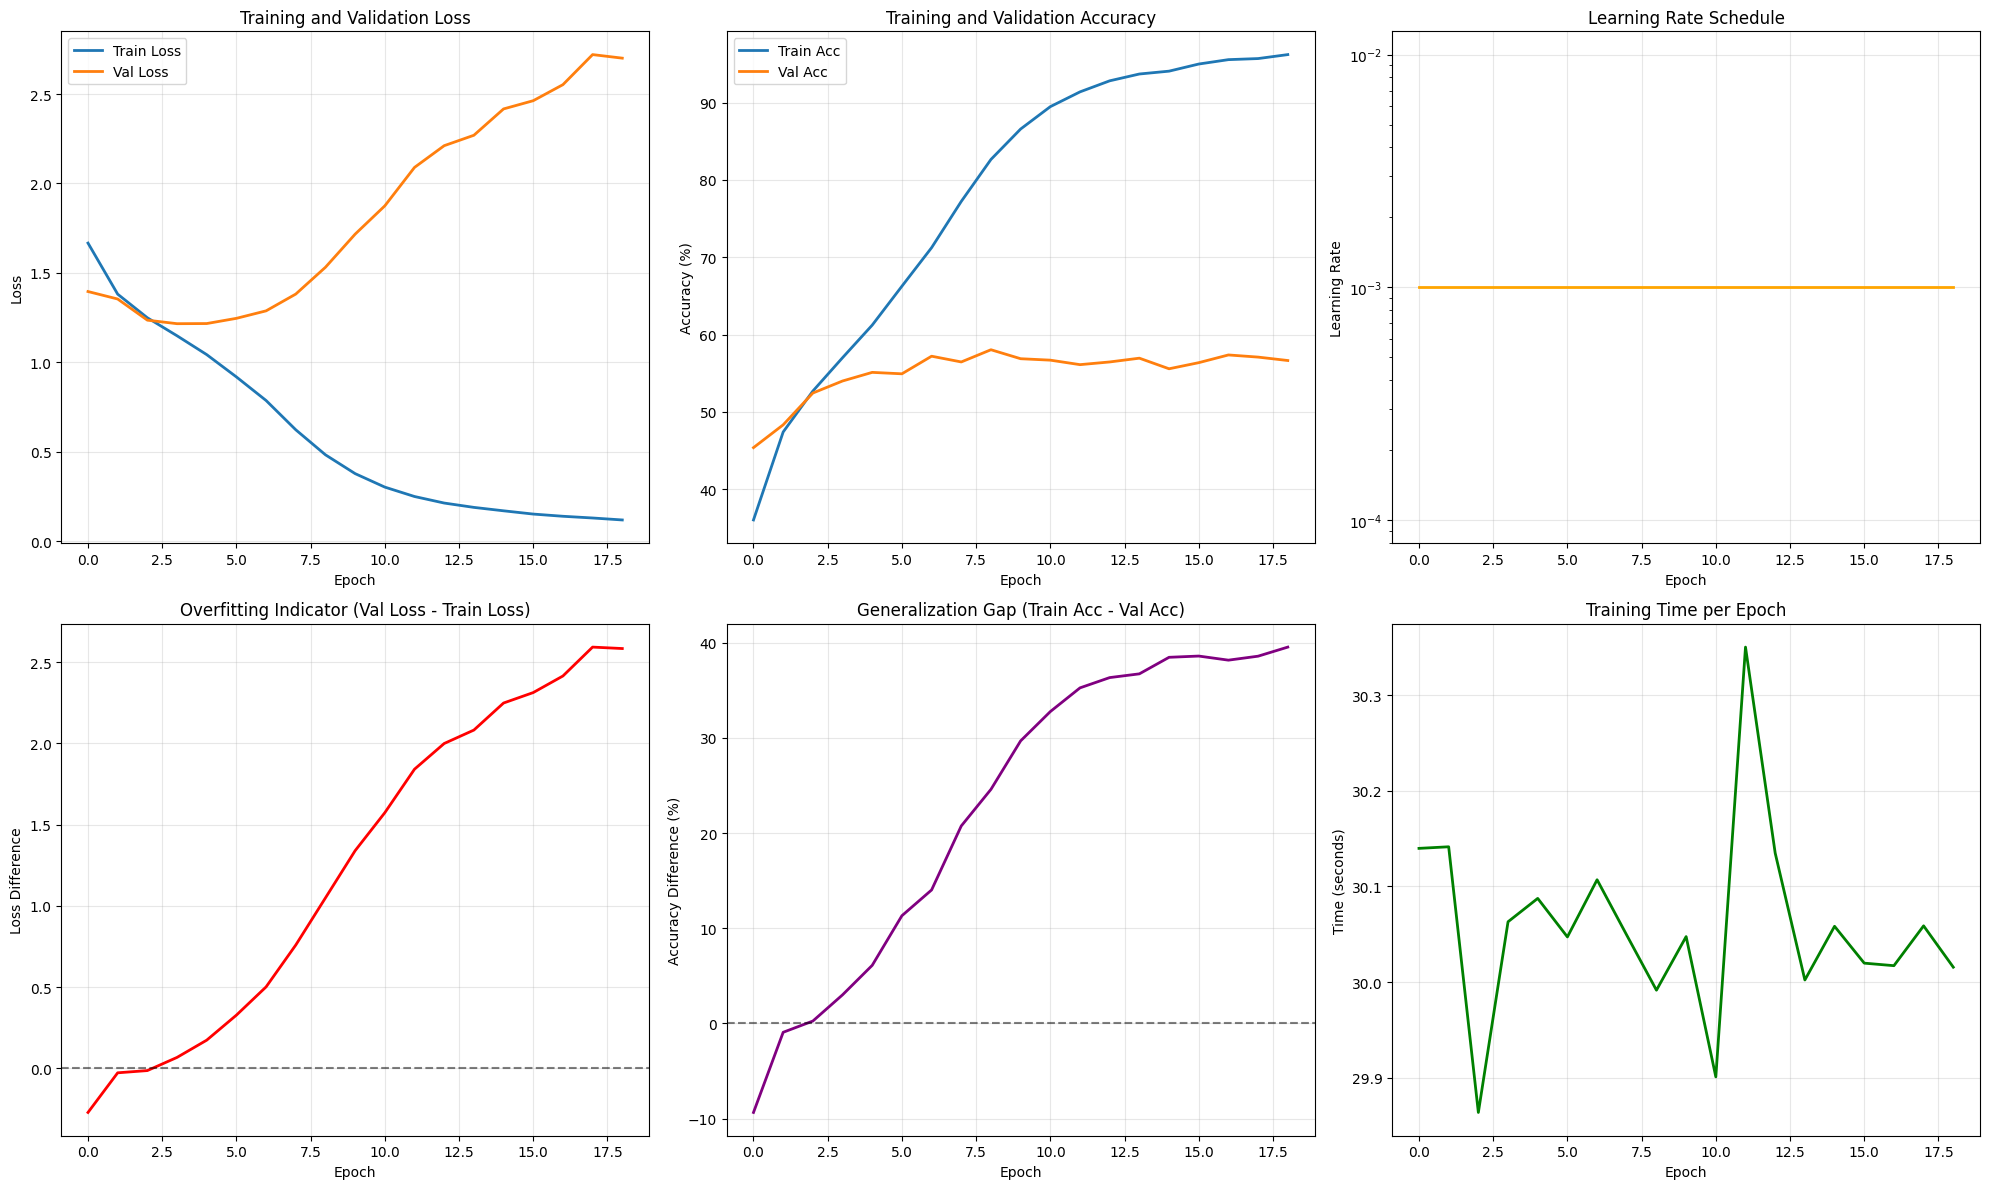


=== OVERFITTING/UNDERFITTING ANALYSIS ===
Final loss gap (val - train): 2.4297
Final accuracy gap (train - val): 38.67%
🔴 OVERFITTING DETECTED
Recommendations:
  - Increase dropout rate
  - Add more regularization
  - Reduce model complexity
  - Increase dataset size or augmentation


In [32]:
print("=== MODEL ANALYSIS ===")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

axes[0, 0].plot(final_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(final_history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(final_history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(final_history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(final_history['learning_rates'], linewidth=2, color='orange')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

loss_gap = np.array(final_history['val_loss']) - np.array(final_history['train_loss'])
axes[1, 0].plot(loss_gap, linewidth=2, color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Overfitting Indicator (Val Loss - Train Loss)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss Difference')
axes[1, 0].grid(True, alpha=0.3)

acc_gap = np.array(final_history['train_acc']) - np.array(final_history['val_acc'])
axes[1, 1].plot(acc_gap, linewidth=2, color='purple')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Generalization Gap (Train Acc - Val Acc)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Difference (%)')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(final_history['epoch_times'], linewidth=2, color='green')
axes[1, 2].set_title('Training Time per Epoch')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Time (seconds)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('advanced_cnn_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

final_loss_gap = loss_gap[-5:].mean()
final_acc_gap = acc_gap[-5:].mean()

print("\n=== OVERFITTING/UNDERFITTING ANALYSIS ===")
print(f"Final loss gap (val - train): {final_loss_gap:.4f}")
print(f"Final accuracy gap (train - val): {final_acc_gap:.2f}%")

if final_loss_gap > 0.2 and final_acc_gap > 5:
    print("🔴 OVERFITTING DETECTED")
    print("Recommendations:")
    print("  - Increase dropout rate")
    print("  - Add more regularization")
    print("  - Reduce model complexity")
    print("  - Increase dataset size or augmentation")
elif final_history['val_acc'][-1] < 50:
    print("🔴 UNDERFITTING DETECTED")
    print("Recommendations:")
    print("  - Increase model complexity")
    print("  - Reduce dropout rate")
    print("  - Train for more epochs")
    print("  - Increase learning rate")
else:
    print("✅ GOOD FIT ACHIEVED")
    print("Model shows good generalization performance")